# Stable Diffusion Deep Dive

Source code is provided by `fastai`'s stable diffusion [GitHub repository](https://github.com/fastai/diffusion-nbs).

## Setup

We will switch gear and use PyTorch instead of TensorFlow for the following sections. We also need a huggingface account for loading the pre-trained models.

In [1]:
# !pip install -q --upgrade transformers diffusers ftfy

In [2]:
from base64 import b64encode
from pathlib import Path

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

In [3]:
# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

In [4]:
torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [5]:
# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

In [6]:
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Models

In [7]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

## Diffusion Loop

We will dig deeper into how a pipeline is set up to run diffusion end to end.

In [8]:
prompt = ["A watercolor painting of an otter"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

Embed text input

In [9]:
text_input = tokenizer(prompt,
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size,
                         padding="max_length",
                         max_length=max_length,
                         return_tensors="pt")

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

# What is unconditional embedding for?
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Scheduler

In [10]:
scheduler.set_timesteps(num_inference_steps)

Latent vectors are going to be fed into U-Net, not the actual image itself.

In [11]:
latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)
latents = latents.to(torch_device)
# Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]
latents = latents * scheduler.init_noise_sigma

Start the loop.

0it [00:00, ?it/s]

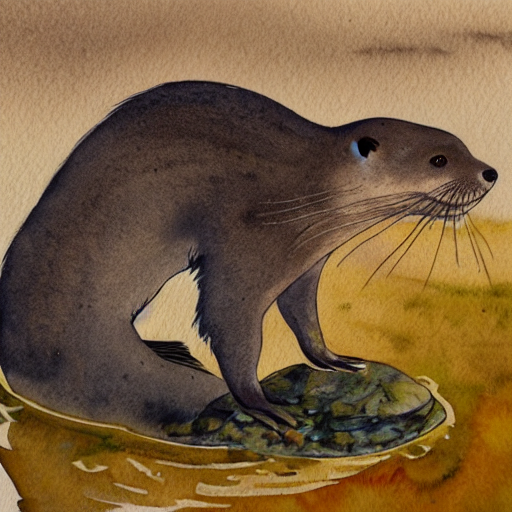

In [12]:
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        #   latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute the previous noisy sample x_t -> x_t-1
        #   latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# Scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample
    
# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

## Variational Autoencoder

The VAE encodes images into latent vectors before sending them to U-Net for generation step. 

In [13]:
def encode_pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()


def decode_latent_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

Download a demo image

In [14]:
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0   994k      0 --:--:-- --:--:-- --:--:--  994k


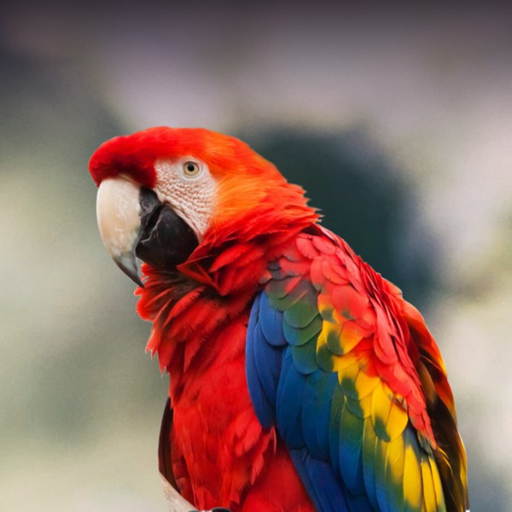

In [15]:
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

Encode the image into latent space, i.e. going from `(512, 512, 3)` to `(64, 64, 4)`.

In [16]:
latent = encode_pil_to_latent(input_image)
latent.shape # PyTorch is usually channel first.

torch.Size([1, 4, 64, 64])

We can inspect what do the latents look like, dimension by dimension.

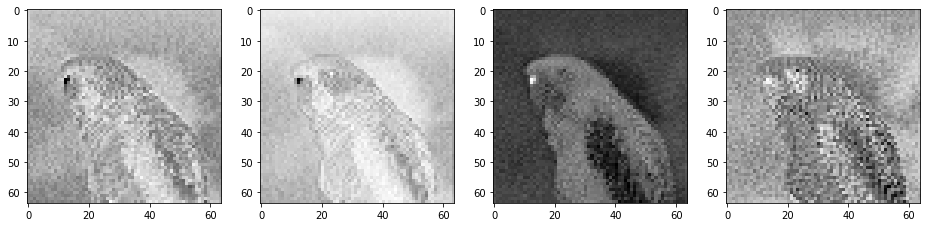

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent[0][c].cpu(), cmap='Greys')

The latents are acting as lossy compressed images.

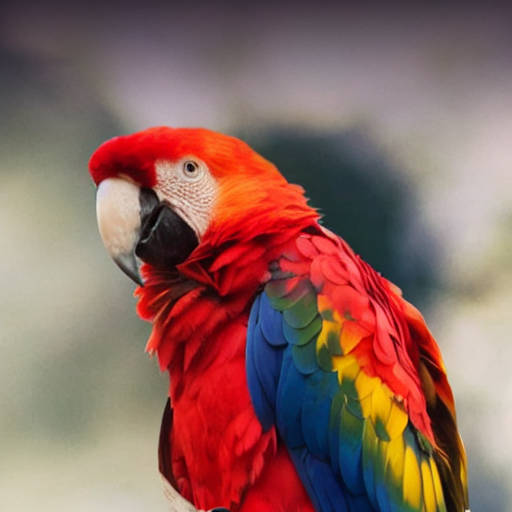

In [18]:
decoded_pil = decode_latent_to_pil(latent)[0]
decoded_pil

The difference is very small. Look at the eye and see the small difference. This is effectively a 48x compression going from input to latent. Thus instead of doing diffusion on image space, we can make it work on latent space because latent space does an excellent job at capturing image information. With 48x reduction, diffusion can be run on much cheaper hardware. This is one of the key innovations of stable diffusion.

## Scheduler

The training objective for a diffusion model is to "predict" noise for a given image. We then subtract the noise from the image to obtain a final image output. When the model is fully trained, we can feed it pure noise and model will output all the noise it sees. When we subtract the noise from a pure noise image, a recognizable image will emerge. 

During **training time**, we need to vary the amount of noise added for every training step. If too much noise, the model doesn't have much information to learn from. If too little noise, the model loses generative ability. We need to follow a schedule to add noise to each training step according to some distribution.

During **sampling time** or inference time, we need to vary the amount of "denoise" for every inference step. We need to make use of the same schedule that we used during training.

This is where the linear multi-step discerete scheduler comes in. 

```py
scheduler = LMSDiscreteScheduler(beta_start=0.00085,
                                 beta_end=0.012,
                                 beta_schedule="scaled_linear",
                                 num_train_timesteps=1000)
```

In [19]:
# Setting the number of sampling steps:
scheduler.set_timesteps(15)

In [20]:
# See these in terms of the original 1000 steps used for training:
scheduler.timesteps

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000], dtype=torch.float64)

In [21]:
# Look at the equivalent noise levels:
scheduler.sigmas

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])

During sampling, we will start at a high noise level (in fact, our input will be pure noise) and gradually 'denoise' down to an image.

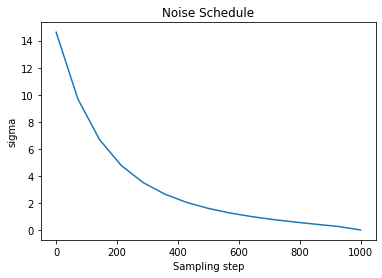

In [22]:
plt.plot(scheduler.timesteps.flip(0), scheduler.sigmas[:-1])
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

Sigma is the amount of noise added to the latent representation. Let's add some noise to an encoded image and see what the decoding will look like.

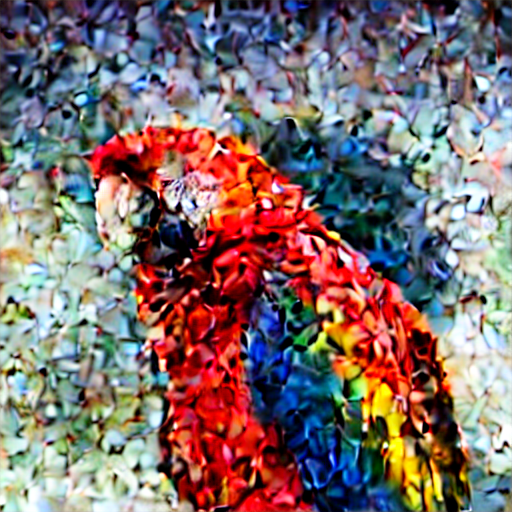

In [23]:
noise = torch.randn_like(latent) # Random noise
sampling_step = 10 # Equivalent to step 10 out of 15 in the schedule above
noisy_latent = scheduler.add_noise(latent,
                                   noise,
                                   timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
decode_latent_to_pil(noisy_latent)[0]

The scheduler's `add_noise` function simply adds noise scaled by sigma.

```py
noisy_samples = original_samples + noise * sigma
```

Other diffusion models may be trained with different noising and scheduling approaches, some of which keep the variance fairly constant across noise levels ('variance preserving') with different scaling and mixing tricks instead of having noisy latents with higher and higher variance as more noise is added ('variance exploding').

If we want to start from random noise instead of a noised image, we need to scale it by the largest sigma value used during training, ~14 in this case. And before these noisy latents are fed to the model they are scaled again in the so-called pre-conditioning step:

```
latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)
```

now handled by scheduler's `scale_model_input` API.

```
latent_model_input = scheduler.scale_model_input(latent_model_input, t)).
```

Again, this scaling/pre-conditioning differs between papers and implementations, so keep an eye out for this if you work with a different type of diffusion model.


## Image2Image Architecture

Instead of using pure noise as starting point, we use an actual image and add noise to it. This will produce a new image that is based on the input image with variations.

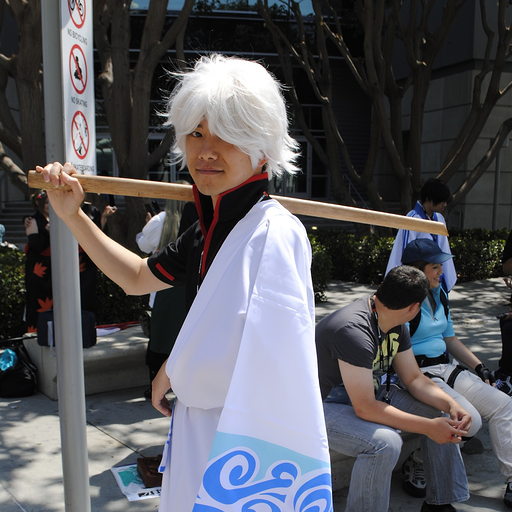

In [90]:
input_image = Image.open('steven.png').resize((512, 512))
latent = encode_pil_to_latent(input_image)
input_image

0it [00:00, ?it/s]

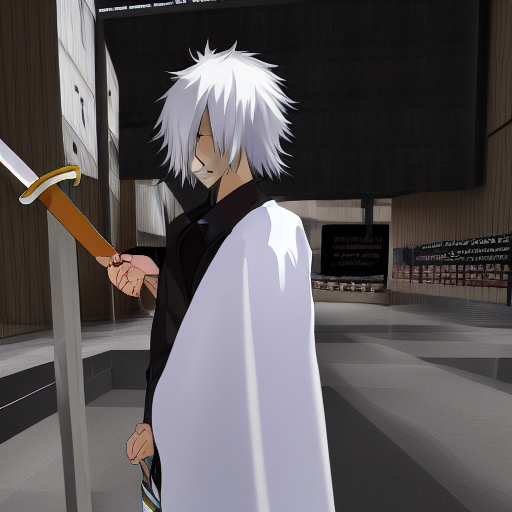

In [122]:
prompt = ["anime characte with a sword on his shoulder"]
height = 512                       # default height of Stable Diffusion
width = 512                        # default width of Stable Diffusion
num_inference_steps = 30           # Number of denoising steps
guidance_scale = 8                 # Scale for classifier-free guidance
generator = torch.manual_seed(3) # Seed generator to create the inital latent noise
batch_size = 1

# Prepare text (same as before)
text_input = tokenizer(prompt,
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size,
                         padding="max_length",
                         max_length=max_length,
                         return_tensors="pt")

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prepare scheduler (setting the number of inference steps)
scheduler.set_timesteps(num_inference_steps)

# Prepare latents (noising appropriately for start_step)
start_step = 12
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(latent)
noisy_latent = scheduler.add_noise(latent, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
noisy_latent = noisy_latent.to(torch_device).float()

# Loop and denoise
# We start at later step to control how much noise we add to the original image.
for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([noisy_latent] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        noisy_latent = scheduler.step(noise_pred, t, noisy_latent).prev_sample


decode_latent_to_pil(noisy_latent)[0]

## Text Embedding via CLIP Encoder

The tokenizer will embed the text prompt as a vector. It will first turn the text into tokens and then tokens become embedding vectors.

In [130]:
prompt = 'A picture of a puppy.'
text_input = tokenizer(prompt,
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")
print("Tokens:", text_input['input_ids'][0])

# See the individual tokens
# Any token after "puppy" is an end-of-text placeholder token.
for t in text_input['input_ids'][0][:8]: 
    print(t, tokenizer.decoder.get(int(t)))

Tokens: tensor([49406,   320,  1674,   539,   320,  6829,   269, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])
tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(269) .</w>
tensor(49407) <|endoftext|>


Now we look at the actual embeddings from the text encoder. The text encoder we use is called `CLIPTextModel` which stands for **contrastive language-image pre-training** text model. This model is trained on pairing text captions with images.

In [131]:
# Grab the output embeddings
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.1316,  0.0377, -0.0954,  ..., -0.7541, -1.3107, -0.2729],
         [-0.1130,  0.0191, -0.0804,  ..., -0.7567, -1.3055, -0.2693],
         [-0.1674,  0.0628, -0.0393,  ..., -0.7345, -1.2996, -0.2786]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

There are two steps to embedding, token embedding and position embedding.

In [132]:
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

### Token Embeddings

We have a vocab size of 49408 and embedding dimension 768.

In [133]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer

Embedding(49408, 768)

The embedding is simply an index look-up.

In [134]:
embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
embedding.shape

torch.Size([768])

We can do it to the whole sentence.

In [135]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### Positional Embedding

Word order matters. We can embed each word position as a vector as well. In fact the text model expects us to provide both token and position embeddings to the encoder. Our sequence max length is 77 so we should expect position embedding to return 77 at `axis=0`.

In [136]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [137]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

### Combining Token and Position Embeddings

We can sum the two vectors for this particular text encoding model to create a final embedding. In other models, the two vectors may be concatenated to form the final embedding vector.

In [138]:
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

The operation is identical to the following.

In [139]:
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

Now if we put them together, this is what we get from the CLIP text encoder.

![CLIP Text Encoder](./clip-text-encoder.png)

In [140]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    batch_size, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(batch_size,
                                                                                 seq_len,
                                                                                 dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True 
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
print(out_embs_test.shape) # Check the output shape
out_embs_test # Inspect the output

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.1316,  0.0377, -0.0954,  ..., -0.7541, -1.3107, -0.2729],
         [-0.1130,  0.0191, -0.0804,  ..., -0.7567, -1.3055, -0.2693],
         [-0.1674,  0.0628, -0.0393,  ..., -0.7345, -1.2996, -0.2786]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

It is identical to the following operation.

In [141]:
text_encoder(text_input.input_ids.to(torch_device))[0]

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.1316,  0.0377, -0.0954,  ..., -0.7541, -1.3107, -0.2729],
         [-0.1130,  0.0191, -0.0804,  ..., -0.7567, -1.3055, -0.2693],
         [-0.1674,  0.0628, -0.0393,  ..., -0.7345, -1.2996, -0.2786]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

### Modify Embeddings

Let's see what happens if we modify one of the tokens.

In [144]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt,
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Positional embeddings
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

# Insert replacement into the token embeddings
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_embeddings = token_emb_layer(input_ids)
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device=torch_device))
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

input_embeddings = token_embeddings + position_embeddings
modified_output_embeddings = get_output_embeds(input_embeddings)
print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

Generate an image with this new embedding.

In [150]:
def generate_with_embeddings(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1
    
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * batch_size,
                             padding="max_length",
                             max_length=max_length,
                             return_tensors="pt")
    
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma
    
    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return decode_latent_to_pil(latents)[0]

0it [00:00, ?it/s]

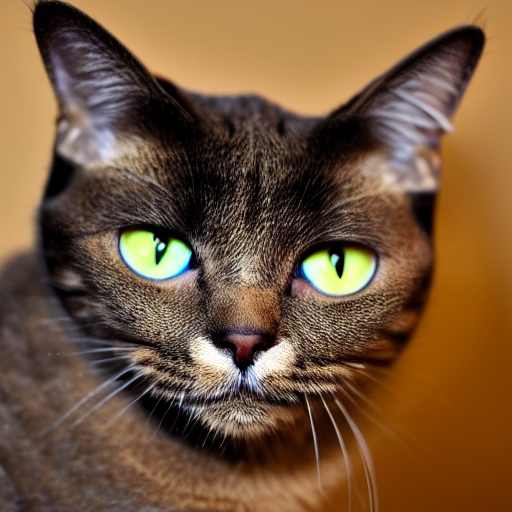

In [151]:
generate_with_embeddings(modified_output_embeddings)

## Mixed Text Encoding

We can mix two different prompt together and assign a weight ratio to them. Let's make a panda cat. First we need to know the token for cat and panda.

In [174]:
print('tokenizer(panda):', tokenizer('panda'))
print('tokenizer(cat):', tokenizer('cat'))

tokenizer(panda): {'input_ids': [49406, 12952, 49407], 'attention_mask': [1, 1, 1]}
tokenizer(cat): {'input_ids': [49406, 2368, 49407], 'attention_mask': [1, 1, 1]}


0it [00:00, ?it/s]

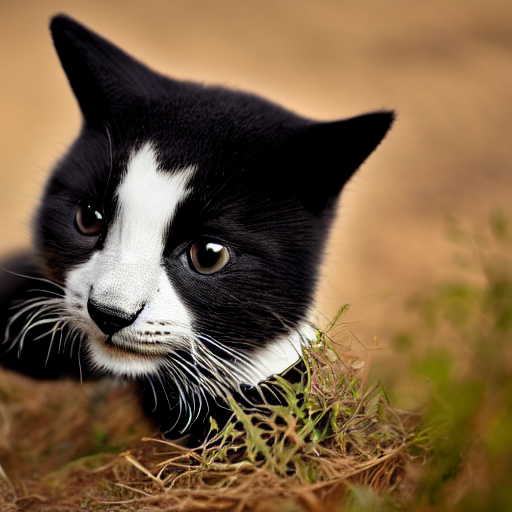

In [176]:
prompt = 'A picture of a cat'

text_input = tokenizer(prompt,
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

position_embeddings = pos_emb_layer(position_ids)
token_embeddings = token_emb_layer(input_ids)

cat_token_embedding = token_emb_layer(torch.tensor(2368, device=torch_device))
panda_token_embedding = token_emb_layer(torch.tensor(12952, device=torch_device))

# Half cat and half panda
replacement_token_embedding = 0.4*cat_token_embedding + 0.6*panda_token_embedding

token_embeddings[0, torch.where(input_ids[0]==2368)] = replacement_token_embedding.to(torch_device)

input_embeddings = token_embeddings + position_embeddings
modified_output_embeddings = get_output_embeds(input_embeddings)
generate_with_embeddings(modified_output_embeddings)

Here's the quick shortcut that will mix two sentences together.

0it [00:00, ?it/s]

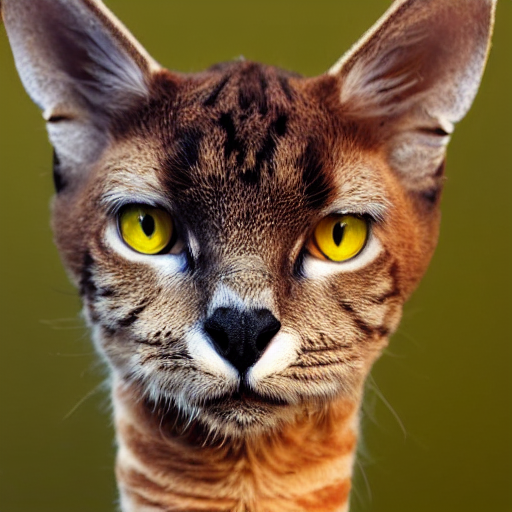

In [183]:
text_input1 = tokenizer(["A giraffe with long neck"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input2 = tokenizer(["A cat with long neck"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings1 = text_encoder(text_input1.input_ids.to(torch_device))[0]
    text_embeddings2 = text_encoder(text_input2.input_ids.to(torch_device))[0]
    
mix_factor = 0.5
mixed_embeddings = text_embeddings1*mix_factor + text_embeddings2*(1-mix_factor)

# Generate!
generate_with_embeddings(mixed_embeddings)

## UNet

We will look into how the de-noising actually works. U-Net takes the latent vector and text embeddings to produce a new latent vector which then decode into image.

In [190]:
scheduler.set_timesteps(num_inference_steps)

t = scheduler.timesteps[0]
sigma = scheduler.sigmas[0]
print("time step", t, "and sigma", sigma)

# Let's take a random noise vector as the input to U-Net
noisy_latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)
noisy_latents = noisy_latents.to(torch_device)
noisy_latents = noisy_latents * scheduler.init_noise_sigma

# Pick a prompt
text_input = tokenizer(['A macaw'],
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Run it through U-Net
with torch.no_grad():
    noise_pred = unet(noisy_latents, t, encoder_hidden_states=text_embeddings)["sample"]
    
noisy_latents.shape, noise_pred.shape

time step tensor(999., dtype=torch.float64) and sigma tensor(14.6146)


(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

Given a set of noisy latents, the model predicts the noise component. We subtract the noise from the noisy latents to generate a denoised latent that can be interpreted as an image, like this.

```
denoised_latents = noisy_latents - sigma * noise_pred
```

Let's visualize the progression of denoising.

In [217]:
prompt = 'Oil painting of an otter in a top hat'
height = 512                      
width = 512                        
num_inference_steps = 50
guidance_scale = 8    
generator = torch.manual_seed(32)
batch_size = 1

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

In [218]:
# Prepare text embeddings
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    
max_length = text_input.input_ids.shape[-1]

# ? Why do we need unconditional inputs for classifier-free guidance?
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [219]:
# Prepare scheduler, use the noise to generate a latent
scheduler.set_timesteps(num_inference_steps)

latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

In [220]:
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # Get the predicted x0:
    # latents_x0 = latents - sigma * noise_pred # If we were to calculate it ourselves
    latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample # Using the scheduler (Diffusers 0.4 and above)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    # To PIL Images
    im_t0 = decode_latent_to_pil(latents_x0)[0]
    im_next = decode_latent_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpeg')

0it [00:00, ?it/s]

In [221]:
# Make and show the progress video (change width to 1024 for full res)
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4

In [222]:
from IPython.display import Video
Video("out.mp4")

The left image is the result of decoding somewhat-noisy latent for every time step. The right image is the result of decoding a fully noise-subtracted latent for every time step. Note that scheduler does not subtract all noises from latent when it produces `prev_sample`. More on this later.

## Classifier Free Guidance

We first need to ask what is a **classifier guidance**?

Excerpt from [Classifier-Free Diffusion Guidance](https://arxiv.org/pdf/2207.12598.pdf):

> Dhariwal & Nichol (2021) proposed a classifier guidance, a technique to boost the sample quality of a diffusion
> model using an extra trained classifier. Prior to classifier guidance, it was not known how to generate low
> temperature samples from a diffusion model... Classifier guidance instead mixes a diffusion model's score
> estimate with the input gradient of the log probability of a classifier.

Low temperature samples refer to denoised samples (in physics, low temperature = high entropy, high temperature = low entropy). The classifier provides "guidance" to the de-noising procedure.

The classifier-free approach is an alternative method of modifying conditional embedding to have the same effect as classifier guidance. That is to use a pair of conditional and unconditional text embedding as a pair of positive/negative sample. The unconditional text embedding is just a sentence of null/placeholder tokens.

```py
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
```

The text embedding is fed into U-Net as a conditional

```py
noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
```

We can break the prediction into two parts, one is based on conditional, another one is based on unconditional. We can break them into two parts.

```
noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
```

The final noise latent prediction is then a linear combination of the two, weighted by guidance scale.

```
noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
```

During training time, the model learns to distinguish conditional vs unconditional. It dcreases the unconditional likelihood of the sample while increasing the conditional likelihood. It is effectively learning to be a classifier.

## Sampling

The model tries to predict noise in an image. For low noise values, it does a pretty good job. For higher noise levels, it struggles. Instead of producing a sharp image, the results tend to look like a blurry mess. Samplers use model predictions to move a small amount towards the model prediction by remving some noises but not all, then get another prediction based on this marginally-less-rubbish input. Different scheduler/sampler does this in different ways.

In [208]:
# ??scheduler.step

## Mess with Guidance

Taking the classifier guidance idea, we can introduce a gradient to guide the image generation process. For example, we want a blue image. We will define a loss function with respect to noisy latents. We take the gradient and use the gradient to modify latent.

In [211]:
def blue_loss(images):
    # How far are the blue channel values to 0.9:
    loss = torch.abs(images[:,2] - 0.9).mean() # [:,2] -> all images in batch, only the blue channel
    return loss

We will update the latent in each time step based on this blue loss.

In [227]:
prompt = 'A campfire (oil on canvas)' 
height = 512                        
width = 512                         
num_inference_steps = 50 
guidance_scale = 8 
generator = torch.manual_seed(32)
batch_size = 1
blue_loss_scale = 50

In [228]:
# Prepare conditional/unconditional embeddings

text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [229]:
# Prepare random latents
scheduler.set_timesteps(num_inference_steps)

latents = torch.randn((batch_size, unet.in_channels, height // 8, width // 8), generator=generator)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

0it [00:00, ?it/s]

0 loss: 45.506813049316406
10 loss: 27.908855438232422
20 loss: 24.215181350708008
30 loss: 23.056489944458008
40 loss: 22.5749454498291


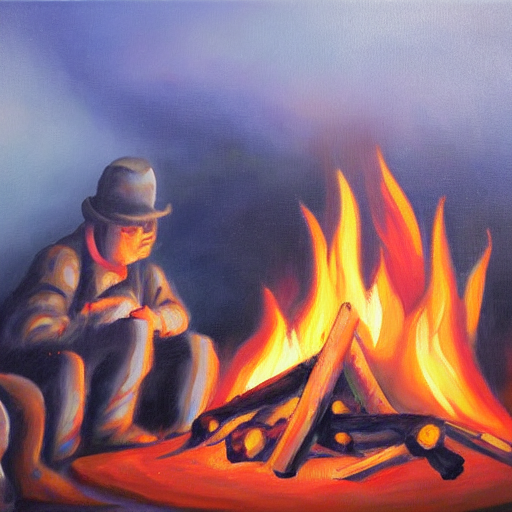

In [230]:
for i, t in tqdm(enumerate(scheduler.timesteps)):
    # Expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # Perform classifier free guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### Blue Guidance ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        # latents_x0 = latents - sigma * noise_pred
        latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = blue_loss(denoised_images) * blue_loss_scale
        
        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2
    
    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    

decode_latent_to_pil(latents)[0]